In [1]:
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imagenes
from skimage import io

import os
from PIL import Image
import shutil
import random


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA está disponible. Tu tarjeta gráfica es:", torch.cuda.get_device_name(0))
else:
    print("CUDA no está disponible. Verifica tus instalaciones.")


CUDA está disponible. Tu tarjeta gráfica es: NVIDIA GeForce GTX 1650


In [3]:
# Location of data
datadir = 'archive/'
traindir =datadir+'Training/'
validdir =datadir+'Validation/'
testdir =datadir+'Testing/'

save_file_name = 'vgg16_transfer-4.pt'
checkpoint_path = 'vgg16_transfer-4.pth'

# Change to fit hardware
batch_size = 1

train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

#If you use multiple gpus it turns statement multi_gpu = True. Probably useful for large datasets
# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False


categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
tumor_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

tumor_df.sort_values('n_train', ascending=False, inplace=True)
tumor_df.head()


Train on gpu: True
1 gpus detected.


,category,n_train,n_valid,n_test
2,notumor,1436,159,405
3,pituitary,1312,145,300
1,meningioma,1206,133,306
0,glioma,1189,132,300


In [4]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        # transforms.RandomResizedCrop(size=200, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=30),
        # transforms.ColorJitter(),
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=64),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        # transforms.Resize(size=64),
        # transforms.CenterCrop(size=180),
        # transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        # transforms.Resize(size=64),
        # transforms.CenterCrop(size=180),
        # transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
}

In [5]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [6]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [7]:
n_classes = len(tumor_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

There are 4 different classes.


4

Las dimensiones son:
(512, 512, 3)


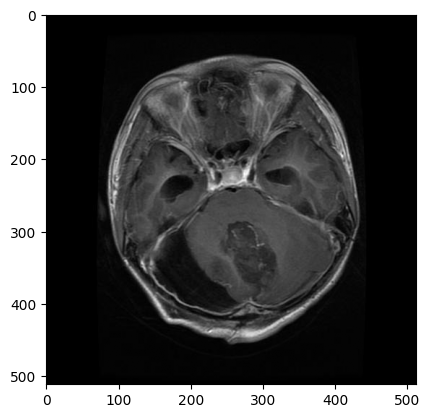

In [8]:
image=io.imread("archive/Testing/glioma/Te-glTr_0000.jpg")/255.0 

print("Las dimensiones son:")
print(image.shape)
plt.imshow(image,vmin=0,vmax=1)

In [9]:
#cargamos la red vgg16
model_vgg19 = models.vgg19(pretrained=True)
model_vgg19

c:\Users\olver\anaconda3\envs\NS_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\olver\anaconda3\envs\NS_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
#Le decimos que no entrene las capas ya entrenadas
for param in model_vgg19.parameters():
    param.requires_grad = False
    
#agregamos la capa de completamente conectada y una softmax
n_inputs = model_vgg19.classifier[6].in_features
model_vgg19.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 128), nn.ReLU(), nn.Dropout(0.4),
    # nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.4),
    # nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(64, n_classes))

model_vgg19.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [11]:
total_params = sum(p.numel() for p in model_vgg19.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_vgg19.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

140,103,172 total parameters.
532,932 training parameters.


In [12]:
if train_on_gpu:
    model = model_vgg19.to('cuda')
    
summary(model_vgg19, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 224, 224]           1,792
              ReLU-2          [1, 64, 224, 224]               0
            Conv2d-3          [1, 64, 224, 224]          36,928
              ReLU-4          [1, 64, 224, 224]               0
         MaxPool2d-5          [1, 64, 112, 112]               0
            Conv2d-6         [1, 128, 112, 112]          73,856
              ReLU-7         [1, 128, 112, 112]               0
            Conv2d-8         [1, 128, 112, 112]         147,584
              ReLU-9         [1, 128, 112, 112]               0
        MaxPool2d-10           [1, 128, 56, 56]               0
           Conv2d-11           [1, 256, 56, 56]         295,168
             ReLU-12           [1, 256, 56, 56]               0
           Conv2d-13           [1, 256, 56, 56]         590,080
             ReLU-14           [1, 256,

In [13]:
#Creamos un mapeo de clases a indices y de indices a clases
model_vgg19.class_to_idx = data['train'].class_to_idx
model_vgg19.idx_to_class = {
    idx: class_
    for class_, idx in model_vgg19.class_to_idx.items()
}

list(model_vgg19.idx_to_class.items())[:10]

[(0, 'glioma'), (1, 'meningioma'), (2, 'notumor'), (3, 'pituitary')]

In [25]:
#Usamos criterio para clasificacion multiple
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg19.parameters(), lr = 0.000001)

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([128, 4096])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


In [26]:
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,
          max_epochs_stop=3,n_epochs=20,print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')


    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [27]:
model, history = train(
    model_vgg19,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=10,
    n_epochs=10,
    print_every=1)

Model has been trained for: 24 epochs.

Epoch: 0	100.00% complete.
Epoch: 0 	Training Loss: 0.4105 	Validation Loss: 0.3185
		Training Accuracy: 84.46%	 Validation Accuracy: 88.22%
Epoch: 1	100.00% complete.
Epoch: 1 	Training Loss: 0.4229 	Validation Loss: 0.3166
		Training Accuracy: 84.21%	 Validation Accuracy: 88.58%
Epoch: 2	100.00% complete.
Epoch: 2 	Training Loss: 0.4215 	Validation Loss: 0.3233
		Training Accuracy: 84.21%	 Validation Accuracy: 87.87%
Epoch: 3	100.00% complete.
Epoch: 3 	Training Loss: 0.4140 	Validation Loss: 0.3208
		Training Accuracy: 84.54%	 Validation Accuracy: 88.58%
Epoch: 4	100.00% complete.
Epoch: 4 	Training Loss: 0.4006 	Validation Loss: 0.3174
		Training Accuracy: 84.87%	 Validation Accuracy: 87.87%
Epoch: 5	100.00% complete.
Epoch: 5 	Training Loss: 0.4033 	Validation Loss: 0.3285
		Training Accuracy: 84.31%	 Validation Accuracy: 87.52%
Epoch: 6	100.00% complete.
Epoch: 6 	Training Loss: 0.4079 	Validation Loss: 0.3171
		Training Accuracy: 84.66%	 V

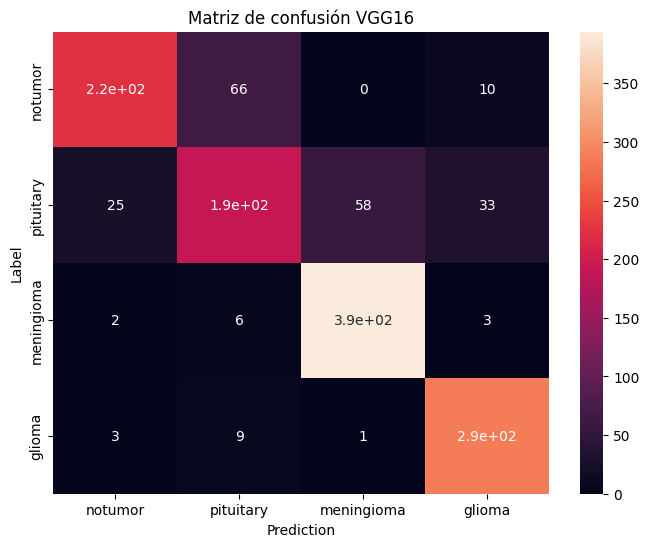

In [44]:
#mapa de calor con la matriz de confusion usando cuda 
import seaborn as sns
from sklearn.metrics import confusion_matrix

def confusion_matrix_compute(model,loader):
    y_pred = []
    y_true = []
    for data, target in loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, pred = torch.max(output, dim=1)
        y_pred.append(pred.item())
        y_true.append(target.item())
    return confusion_matrix(y_true,y_pred)

cm = confusion_matrix_compute(model,dataloaders['test'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True,xticklabels=tumor_df['category'].values, yticklabels=tumor_df['category'].values)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Matriz de confusión VGG16')
plt.show()

In [45]:
#calificamos con el conjunto de test
def test_model(model, test_loader, criterion):
    test_acc = 0.0
    test_loss = 0.0

    model.eval()
    for data, target in test_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        #obtenemos la salida del modelo
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

        test_acc += accuracy.item() * data.size(0)

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_acc / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}\tTest Accuracy: {100 * test_acc:.2f}%')

    return test_loss, test_acc


test_model(model, dataloaders['test'], criterion)

Test Loss: 0.4133	Test Accuracy: 83.22%


(0.4133416285422414, 0.8321891685736079)

In [47]:
#Calculamos el recall del conjuto test
from sklearn.metrics import recall_score
y_pred = []
y_true = []
for data, target in dataloaders['test']:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    _, pred = torch.max(output, dim=1)
    y_pred.append(pred.item())
    y_true.append(target.item())
recall_score(y_true,y_pred,average='macro')


0.8219026870007262

Text(0.5, 1.0, 'Training and Validation Losses')

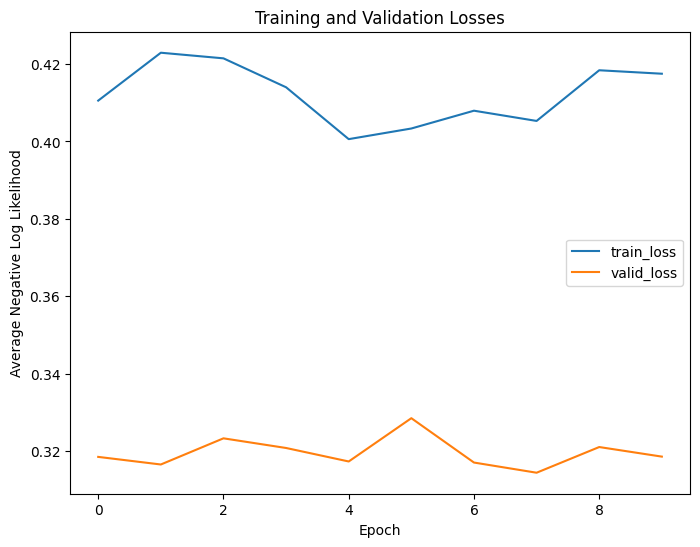

In [28]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

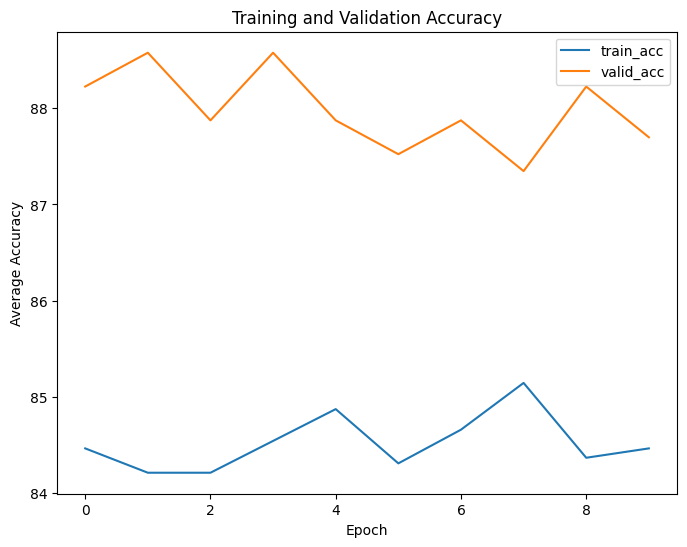

In [29]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [36]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16_transfer', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16_transfer':
        checkpoint['classifier'] = model.classifier
        checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        checkpoint['fc'] = model.fc
        checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [37]:
save_checkpoint(model, path=checkpoint_path)

In [40]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16_transfer', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16_transfer':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']


    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')


    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [41]:
model, optimizer = load_checkpoint(path=checkpoint_path)
summary(model, input_size=(3, 224, 224), batch_size=batch_size)

RuntimeError: Error(s) in loading state_dict for VGG:
	Missing key(s) in state_dict: "features.17.weight", "features.17.bias", "features.24.weight", "features.24.bias", "features.26.weight", "features.26.bias". 
	Unexpected key(s) in state_dict: "features.32.weight", "features.32.bias", "features.34.weight", "features.34.bias", "features.16.weight", "features.16.bias", "features.23.weight", "features.23.bias", "features.25.weight", "features.25.bias", "features.30.weight", "features.30.bias". 
	size mismatch for features.19.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 512, 3, 3]).

In [42]:

model, history = train(model,criterion,optimizer,dataloaders['train'],dataloaders['val'],
                       save_file_name=save_file_name,max_epochs_stop=5,n_epochs=30,print_every=1)

Model has been trained for: 0 epochs.



KeyboardInterrupt: 